In [236]:
from DataVisualisation import DataVisualisation
import ParametricalIdentification as pi
import pandas as pd
import numpy as np
import pandas as pd




In [237]:
import numpy as np

def numerical_derivative(func, x, h=1e-5):
    """
    Function to calculate derivative using finite difference method.

    Parameters:
    func (callable): Function to find derivative for.
    x (float or np.ndarray): Point(s) to calculate derivative at.
    h (float): Step for finite differences (default 1e-5).

    Returns:
    derivative: Derivative of function at point(s) x.
    """
    return (func(x + h) - func(x - h)) / (2 * h)
import numpy as np

def numerical_derivative_array(y, x):
    """
    Calculation of numerical derivate (central distribution)
    """
    dy = np.zeros_like(y)
    dy[1:-1] = (y[2:] - y[:-2]) / (x[2:] - x[:-2])
    dy[0] = (y[1] - y[0]) / (x[1] - x[0])
    dy[-1] = (y[-1] - y[-2]) / (x[-1] - x[-2])
    return dy




### Download data

In [238]:
# download data
import yfinance as yf
from DataPreparation import DataPreparation


url_gold = 'https://thedocs.worldbank.org/en/doc/18675f1d1639c7a34d463f59263ba0a2-0050012025/related/CMO-Historical-Data-Monthly.xlsx'
save_path_gold = 'data/gold_data.xlsx'

url_gpr = 'https://www.matteoiacoviello.com/gpr_files/data_gpr_export.xls' # Geopolitical Risk Index
save_path_grp = 'data/data_gpr_export.xls'

url_gld_us = 'https://www.spdrgoldshares.com/assets/dynamic/GLD/GLD_US_archive_EN.csv' # ETF Holdings (SPDR Gold Shares)
save_path_gld = 'data/GLD_US_archive_EN.csv'

url_debt_us = 'https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23ebf3fb&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1320&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=GFDEBTN&scale=left&cosd=1966-01-01&coed=2024-10-01&line_color=%230073e6&link_values=false&line_style=solid&mark_type=none&mw=3&lw=3&ost=-99999&oet=99999&mma=0&fml=a&fq=Quarterly%2C%20End%20of%20Period&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2025-05-24&revision_date=2025-05-24&nd=1966-01-01' # USA national debt
save_path_debt = 'data/debt_data.csv'


"""

# Download VIX data for the last 5 years. SOURCE: #https://finance.yahoo.com/quote/%5EVIX/history/
debt = yf.Ticker("^VIX")
vix_data = debt.history(period="100y")

# Save data into csv
vix_data.to_csv("data/vix_data.csv")  

# Download DXY data for the last 100 years (if available)
# SOURCE: https://finance.yahoo.com/quote/DX-Y.NYB/history/
debt = yf.Ticker("DX-Y.NYB")
dxy_data = debt.history(period="100y")

# Save data into CSV
dxy_data.to_csv("data/dxy_data.csv")





dp = DataPreparation()

#dp.download_file(url_debt_us, save_path_debt)

dp.download_file(url_gpr, save_path_grp)

dp.download_file(url_gold, save_path_gold)

dp.download_file(url_gld_us, save_path_gld)
"""




'\n\n# Download VIX data for the last 5 years. SOURCE: #https://finance.yahoo.com/quote/%5EVIX/history/\ndebt = yf.Ticker("^VIX")\nvix_data = debt.history(period="100y")\n\n# Save data into csv\nvix_data.to_csv("data/vix_data.csv")  \n\n# Download DXY data for the last 100 years (if available)\n# SOURCE: https://finance.yahoo.com/quote/DX-Y.NYB/history/\ndebt = yf.Ticker("DX-Y.NYB")\ndxy_data = debt.history(period="100y")\n\n# Save data into CSV\ndxy_data.to_csv("data/dxy_data.csv")\n\n\n\n\n\ndp = DataPreparation()\n\n#dp.download_file(url_debt_us, save_path_debt)\n\ndp.download_file(url_gpr, save_path_grp)\n\ndp.download_file(url_gold, save_path_gold)\n\ndp.download_file(url_gld_us, save_path_gld)\n'

### Download CPI data

        Date  CPI
0 1913-01-01  9.8
1 1913-02-01  9.8
2 1913-03-01  9.8
3 1913-04-01  9.8
4 1913-05-01  9.7


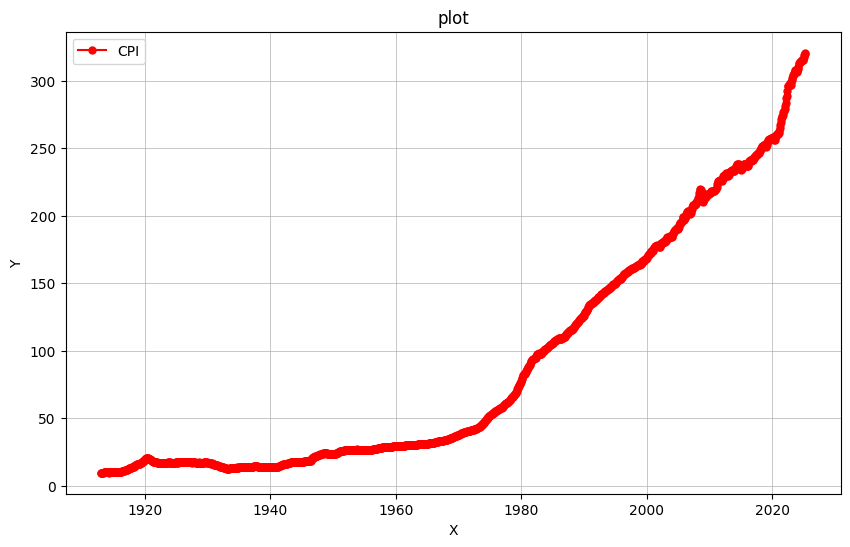

In [239]:
import pandas_datareader.data as web
from datetime import datetime

# SOURCE: https://www.bls.gov/cpi/data.htm
# Start date
start = datetime(1913, 1, 1)

# Download CPI (all goods, month, no season)
cpi = web.DataReader("CPIAUCNS", "fred", start)

# rename
cpi = cpi.rename(columns={"CPIAUCNS": "CPI"})

# turn index into column
cpi = cpi.reset_index()
cpi = cpi.rename(columns={"DATE": "Date"})



dv = DataVisualisation()
print(cpi.head())
cpi_plot = dv.plot_dataframe(cpi,'Date', 'CPI')
cpi_plot.show()

### Read GPR

       month        GPR       GPRH
0 1900-01-01  87.927849  87.927849
1 1900-02-01  86.566490  86.566490
2 1900-03-01  72.140701  72.140701
3 1900-04-01  54.419449  54.419449
4 1900-05-01  64.405197  64.405197


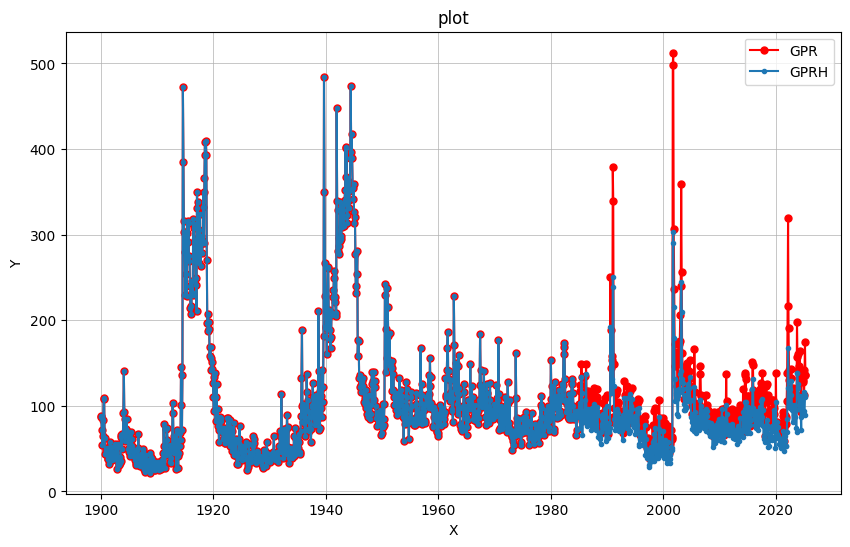

In [240]:
# read xlsx as pandas dataframe
gpr = pd.read_excel(save_path_grp, usecols=[0,1,4])
gpr["GPR"] = gpr["GPR"].fillna(gpr["GPRH"])
print(gpr.head())
dv = DataVisualisation()
gpr_plot = dv.plot_dataframe(gpr,'month', 'GPR',else_y_cols=['GPRH'])
gpr_plot.show()

gpr = gpr[["month","GPR"]]


### Read ETF Holdings (SPDR Gold Shares) data

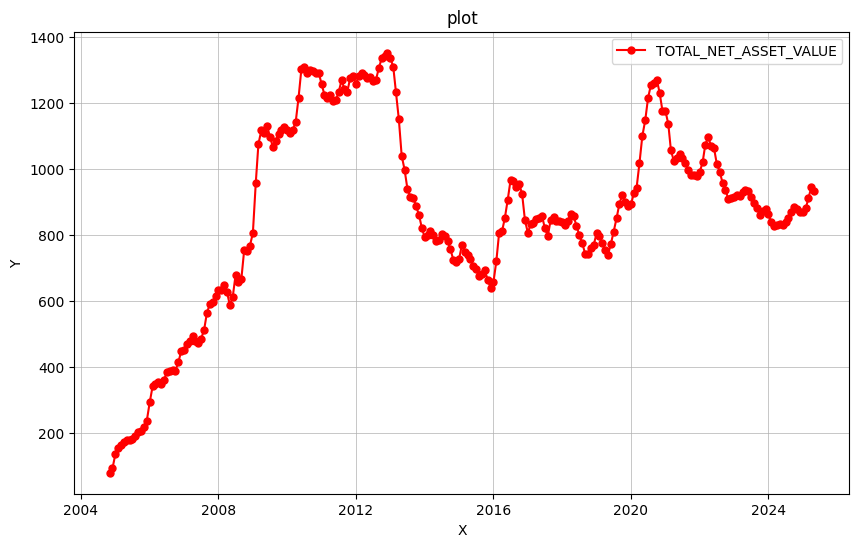

In [241]:
# read csv as pandas dataframe
gld = pd.read_csv(
    save_path_gld,
    parse_dates=["Date"],
    dayfirst=True,
    na_values=["HOLIDAY"]
)

# Remove extra spaces in column headers
gld.columns = gld.columns.str.strip()

# Rename the required column
gld = gld.rename(columns={
    "Total Net Asset Value Tonnes in the Trust as at 4.15 p.m. NYT": "TOTAL_NET_ASSET_VALUE"
})

# Convert the column to numeric type
gld["TOTAL_NET_ASSET_VALUE"] = pd.to_numeric(gld["TOTAL_NET_ASSET_VALUE"], errors="coerce")

# Remove rows with NaN values
gld = gld.dropna(subset=["TOTAL_NET_ASSET_VALUE"])

# Keep only the necessary columns
gld = gld[["Date", "TOTAL_NET_ASSET_VALUE"]]

# Add a month column
gld["Month"] = gld["Date"].dt.to_period("M")

# Calculate the monthly average
monthly_avg = gld.groupby("Month")["TOTAL_NET_ASSET_VALUE"].mean().reset_index()
monthly_avg["Month"] = monthly_avg["Month"].dt.to_timestamp()
gld = monthly_avg
dv = DataVisualisation()

# Plot the data
debt_plot = dv.plot_dataframe(gld, 'Month', 'TOTAL_NET_ASSET_VALUE')
debt_plot.show()

### Read VIX data

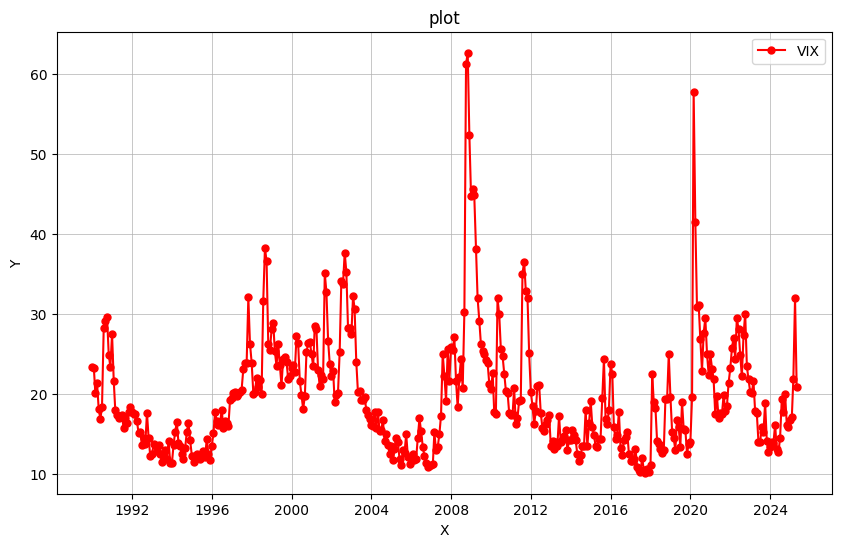

In [242]:

# Step 1: Read CSV
vix = pd.read_csv("data/vix_data.csv")

# Step 2: Clean column names
vix.columns = vix.columns.str.strip()

# Step 3: Rename "Close" column to "VIX"
vix = vix.rename(columns={"Close": "VIX"})

# Step 4: Convert Date to datetime with utc=True, then drop timezone
vix["Date"] = pd.to_datetime(vix["Date"], errors="coerce", utc=True)
vix["Date"] = vix["Date"].dt.tz_convert(None)

# Step 5: Convert VIX to numeric
vix["VIX"] = pd.to_numeric(vix["VIX"], errors="coerce")

# Step 6: Remove rows with missing data
vix = vix.dropna(subset=["Date", "VIX"])

# Step 7: Keep only relevant columns
vix = vix[["Date", "VIX"]]

# Step 8: Add "Month" column and calculate monthly average
vix["Month"] = vix["Date"].dt.to_period("M")
monthly_avg = vix.groupby("Month")["VIX"].mean().reset_index()
monthly_avg["Month"] = monthly_avg["Month"].dt.to_timestamp()
vix = monthly_avg
# Step 9: Plot
dv = DataVisualisation()
vix_plot = dv.plot_dataframe(monthly_avg, 'Month', 'VIX')
vix_plot.show()


### Read dxy data

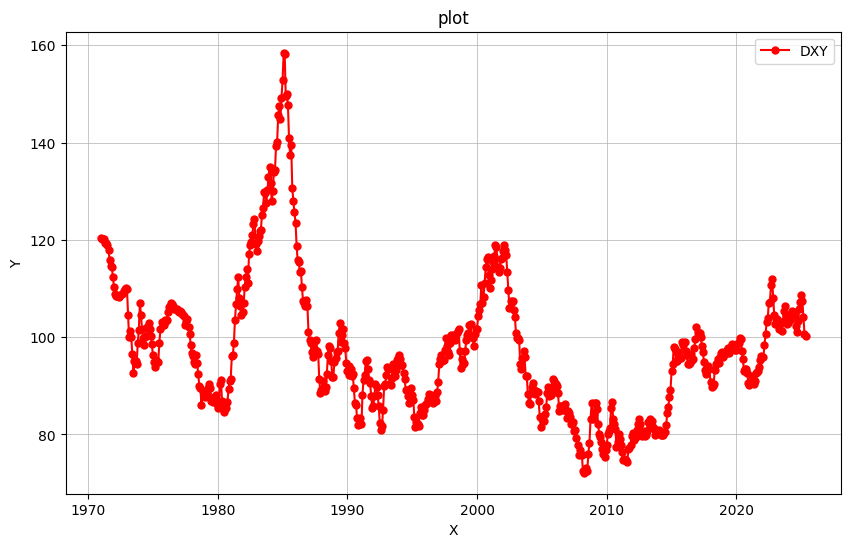

In [243]:

# Step 1: Read CSV
dxy = pd.read_csv("data/dxy_data.csv")

# Step 2: Clean column names
dxy.columns = dxy.columns.str.strip()

# Step 3: Rename "Close" column to "DXY"
dxy = dxy.rename(columns={"Close": "DXY"})

# Step 4: Convert Date to datetime with utc=True, then drop timezone
dxy["Date"] = pd.to_datetime(dxy["Date"], errors="coerce", utc=True)
dxy["Date"] = dxy["Date"].dt.tz_convert(None)

# Step 5: Convert DXY to numeric
dxy["DXY"] = pd.to_numeric(dxy["DXY"], errors="coerce")

# Step 6: Remove rows with missing data
dxy = dxy.dropna(subset=["Date", "DXY"])

# Step 7: Keep only relevant columns
dxy = dxy[["Date", "DXY"]]

# Step 8: Add "Month" column and calculate monthly average
dxy["Month"] = dxy["Date"].dt.to_period("M")
monthly_avg = dxy.groupby("Month")["DXY"].mean().reset_index()
monthly_avg["Month"] = monthly_avg["Month"].dt.to_timestamp()

dxy = monthly_avg

# Step 9: Plot
dv = DataVisualisation()
debt_plot = dv.plot_dataframe(monthly_avg, 'Month', 'DXY')
debt_plot.show()


### Read gold data

          Date     Gold
85  1967-01-01    34.95
86  1967-02-01    34.95
87  1967-03-01    34.95
88  1967-04-01    34.95
89  1967-05-01    34.95
..         ...      ...
780 2024-12-01  2648.01
781 2025-01-01  2709.69
782 2025-02-01  2894.73
783 2025-03-01  2983.25
784 2025-04-01  3217.64

[700 rows x 2 columns]


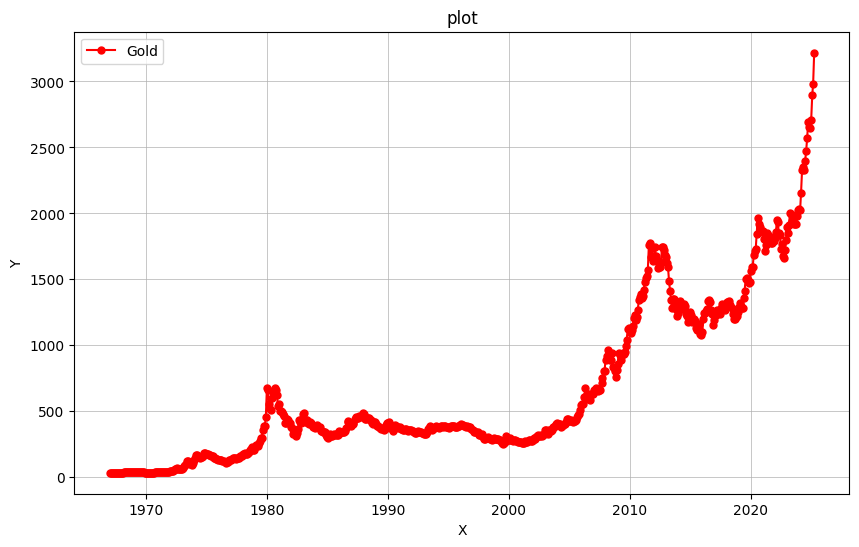

In [244]:

gold = pd.read_excel(
    "data/gold_data.xlsx",
    sheet_name="Monthly Prices",
    skiprows=4 
)

# Rename columns
gold = gold.rename(columns={"Unnamed: 0": "Date"})
gold = gold.rename(columns={"Gold": "Gold"})
gold = gold[['Date','Gold']]
gold = gold.drop(index=0) 
# Convert Date to datetime
gold["Date"] = pd.to_datetime(gold["Date"].str.replace("M", "-") + "-01")

# Filter data from 1967 onward
gold = gold[gold["Date"] >= pd.to_datetime("1967-01-01")]

print(gold)

dv = DataVisualisation()
debt_plot = dv.plot_dataframe(gold, 'Date', 'Gold')
debt_plot.show()

### Read debt data

        Date           Debt
0 1966-01-01  320999.000000
1 1966-02-01  319365.000000
2 1966-03-01  317731.000000
3 1966-04-01  316097.000000
4 1966-05-01  318980.666667


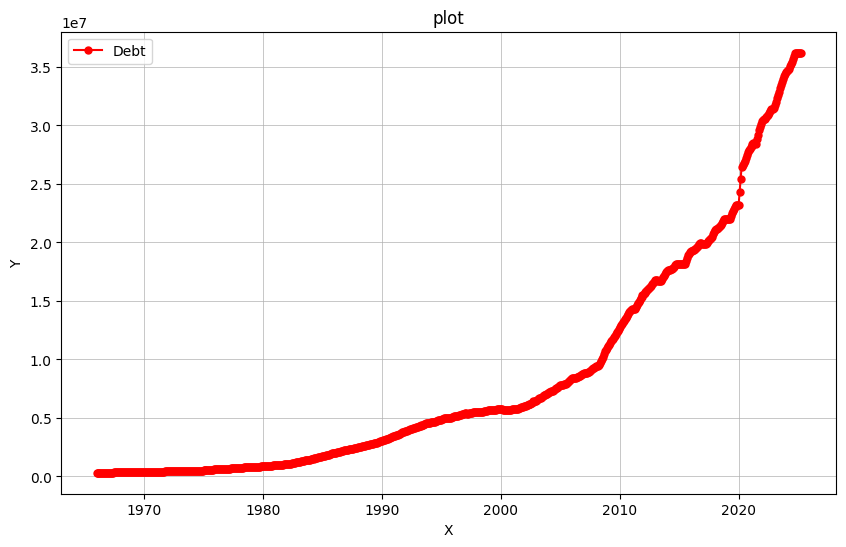

In [245]:
# Step 1: Read CSV
debt = pd.read_csv("data/debt_data.csv")

# Step 2: Clean column names
debt.columns = debt.columns.str.strip()

# Step 3: Rename columns
debt = debt.rename(columns={"observation_date": "Date"})
debt = debt.rename(columns={"GFDEBTN": "Debt"})


# Step 4: Convert Date to datetime with utc=True, then drop timezone
debt["Date"] = pd.to_datetime(debt["Date"], errors="coerce", utc=True)
debt["Date"] = debt["Date"].dt.tz_convert(None)


# Step 8: Add "Month" column and calculate monthly average
debt["Month"] = debt["Date"].dt.to_period("M")
monthly_avg = debt.groupby("Month")["Debt"].mean().reset_index()
monthly_avg["Month"] = monthly_avg["Month"].dt.to_timestamp()
debt = monthly_avg

# Step 9: Create full monthly date range
full_months = pd.date_range(start=debt["Month"].min(), end=debt["Month"].max(), freq='MS')
full_df = pd.DataFrame({"Month": full_months})

# Step 10: Merge with existing data
debt = pd.merge(full_df, debt, on="Month", how="left")

# Step 11: Forward fill to fill missing months with previous quarter value
debt_interpolated = debt
debt_interpolated["Debt"] = debt["Debt"].interpolate(method="linear")
debt_interpolated = debt_interpolated.rename(columns={"Month": "Date"})

debt["Debt"] = debt["Debt"].ffill()
print(debt_interpolated.head())
# Step 12: Plot again
dv = DataVisualisation()
debt_plot = dv.plot_dataframe(debt_interpolated, 'Date', 'Debt')
debt_plot.show()


### Unite data frames

In [246]:
"""
print(debt.head())
print(gold.head())
print(vix.head())
print(dxy.head())
print(gld.head())
print(gpr.head())
print(cpi.head())
"""
# Step 1: Rename date columns to a common name
debt = debt.rename(columns={"Month": "Date"})
vix = vix.rename(columns={"Month": "Date"})
dxy = dxy.rename(columns={"Month": "Date"})
gld = gld.rename(columns={"Month": "Date"})
gpr = gpr.rename(columns={"month": "Date"})  # already datetime
cpi = cpi.rename(columns={"Date": "Date"})
gold = gold.rename(columns={"Date": "Date"})

# Step 2: Ensure all 'Date' columns are datetime
for df in [debt, vix, dxy, gld, gpr, cpi, gold]:
    df["Date"] = pd.to_datetime(df["Date"], errors='coerce')

# Step 3: Merge all dataframes on the 'Date' column using outer join
merged = debt.copy()
merged = merged.merge(gold, on="Date", how="outer")
merged = merged.merge(vix, on="Date", how="outer")
merged = merged.merge(dxy, on="Date", how="outer")
merged = merged.merge(gld, on="Date", how="outer")
merged = merged.merge(gpr, on="Date", how="outer")
merged = merged.merge(cpi, on="Date", how="outer")

# Step 4: Sort the combined dataframe by date
merged = merged.sort_values("Date").reset_index(drop=True)

# Step 5: Keep only rows where gold price is not NaN
merged = merged[merged["Gold"].notna()].reset_index(drop=True)

print(merged.head())  # Inspect merged result


merged.to_csv("data/merged_filtered_data.csv", index=False)




        Date           Debt   Gold  VIX  DXY  TOTAL_NET_ASSET_VALUE  \
0 1967-01-01  330947.000000  34.95  NaN  NaN                    NaN   
1 1967-02-01  328262.333333  34.95  NaN  NaN                    NaN   
2 1967-03-01  325577.666667  34.95  NaN  NaN                    NaN   
3 1967-04-01  322893.000000  34.95  NaN  NaN                    NaN   
4 1967-05-01  327227.333333  34.95  NaN  NaN                    NaN   

          GPR   CPI  
0   78.875809  32.9  
1   93.530823  32.9  
2  106.475494  33.0  
3   86.284355  33.1  
4  124.016533  33.2  


Index(['year', 'Gold', 'Debt', 'Gold_exponent', 'Debt_polynomial',
       'Debt_poly_deriv', 'Gold_exponent_deriv'],
      dtype='object')


C:\Users\ieand\AppData\Local\Temp\ipykernel_17124\2989281994.py:33: RuntimeWarning: invalid value encountered in power
  merged_df['Debt_poly_deriv'] = numerical_derivative(lambda x: popt_debt[0]*x**popt_debt[1] + popt_debt[2],x_year)


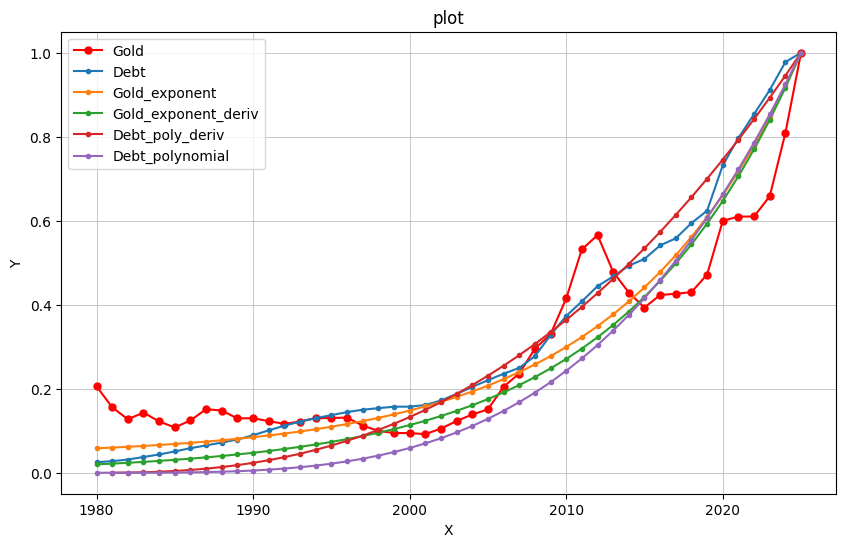

3049.5091742563473


In [279]:
# --- Data Preparation ---
h_gold_price = merged[['Date', 'Gold']].dropna()  # Handle NaNs
debt_interpolated = debt_interpolated.dropna()  # Handle NaNs
debt_interpolated['year'] = debt_interpolated['Date'].dt.year
h_gold_price['year'] = h_gold_price['Date'].dt.year

# Grouping data by year and calculating the average
yearly_avg_gold = h_gold_price.groupby('year')['Gold'].mean().reset_index()
yearly_avg_debt = debt_interpolated.groupby('year')['Debt'].mean().reset_index()

merged_df = pd.merge(yearly_avg_gold, yearly_avg_debt, on='year', how='outer').dropna()
merged_df = merged_df.sort_values('year')

# --- Curve Fitting ---
x_year = merged_df['year'].values - merged_df['year'].min()  # Normalize x-axis

# Initial guesses (these might need adjustment)
initial_guess_gold = [50, 0.05, 100]
initial_guess_debt = [67,3,400]
# Fit gold prices
popt_gold= pi.general_least_squares_fit(x_year, merged_df['Gold'].values, pi.exponential_func, initial_guess_gold,'exponent', epsilon=1e-6, max_iter=500)
merged_df['Gold_exponent'] = pi.exponential_func(x_year, *popt_gold)

# Fit USD debt
popt_debt = pi.general_least_squares_fit(x_year, merged_df['Debt'].values, pi.polynomial_func, initial_guess_debt, 'polynomial', epsilon=1e-6, max_iter=500)
merged_df['Debt_polynomial'] = pi.polynomial_func(x_year, *popt_debt)

# --- Analytical Derivative ---
# Derivative of a*exp(b*x) is a*b*exp(b*x)
def exponential_derivative(x, a, b,c):
    return a * b * np.exp(b * x)

merged_df['Debt_poly_deriv'] = numerical_derivative(lambda x: popt_debt[0]*x**popt_debt[1] + popt_debt[2],x_year)
merged_df['Gold_exponent_deriv'] = exponential_derivative(x_year, popt_gold[0], popt_gold[1], popt_gold[2])

# --- Normalization ---
merged_df['Gold'] = merged_df['Gold'] / merged_df['Gold'].max()
merged_df['Debt'] = merged_df['Debt'] / merged_df['Debt'].max()
merged_df['Gold_exponent'] = merged_df['Gold_exponent'] / merged_df['Gold_exponent'].max()
merged_df['Debt_polynomial'] = merged_df['Debt_polynomial'] / merged_df['Debt_polynomial'].max()
merged_df['Debt_poly_deriv'] = merged_df['Debt_poly_deriv'] / merged_df['Debt_poly_deriv'].max()
merged_df['Gold_exponent_deriv'] = merged_df['Gold_exponent_deriv'] / merged_df['Gold_exponent_deriv'].max()

# --- Plotting ---
print(merged_df.columns)
debt_plot = dv.plot_dataframe(merged_df,'year', 'Gold',else_y_cols=['Debt','Gold_exponent', 'Gold_exponent_deriv','Debt_poly_deriv','Debt_polynomial'])
debt_plot.show()

print(pi.exponential_func(max(x_year)+1.6, *popt_gold))

#### Constructing Debt_poly_deriv 

In [277]:


# --- Monthly Index Construction ---
start_year = merged_df['year'].min()  
monthly_df = pd.date_range(start=h_gold_price['Date'].min(), end=h_gold_price['Date'].max(), freq='MS')
monthly_df = pd.DataFrame({'month': monthly_df})

monthly_df['index_month'] = (monthly_df['month'].dt.year - start_year + 1) + (monthly_df['month'].dt.month - 1) / 12.0

# --- Apply fitted models ---
monthly_df['Gold_exponent'] = pi.exponential_func(monthly_df['index_month'], *popt_gold)
monthly_df['Debt_polynomial'] = pi.polynomial_func(monthly_df['index_month'], *popt_debt)

# --- Derivatives ---

monthly_df['Gold_exponent_deriv'] = exponential_derivative(monthly_df['index_month'], popt_gold[0], popt_gold[1], popt_gold[2])
monthly_df['Debt_poly_deriv'] = numerical_derivative(
    lambda x: popt_debt[0] * x**popt_debt[1] + popt_debt[2], monthly_df['index_month']
)

monthly_df = monthly_df.rename(columns={'month': 'Date'})
print(monthly_df)

          Date  index_month  Gold_exponent  Debt_polynomial  \
0   1980-01-01     1.000000     159.474363     4.707659e+02   
1   1980-02-01     1.083333     159.879060     4.926215e+02   
2   1980-03-01     1.166667     160.286703     5.190959e+02   
3   1980-04-01     1.250000     160.697316     5.507292e+02   
4   1980-05-01     1.333333     161.110918     5.880809e+02   
..         ...          ...            ...              ...   
539 2024-12-01    45.916667    2879.364956     4.326558e+07   
540 2025-01-01    46.000000    2899.576344     4.354047e+07   
541 2025-02-01    46.083333    2919.934913     4.381661e+07   
542 2025-03-01    46.166667    2940.441738     4.409399e+07   
543 2025-04-01    46.250000    2961.097896     4.437263e+07   

     Gold_exponent_deriv  Debt_poly_deriv  
0               4.838761     2.366553e+02  
1               4.873997     2.889197e+02  
2               4.909491     3.475464e+02  
3               4.945242     4.127720e+02  
4               4.98125

#### Merge results and calculate gold derivation

In [249]:
# merge DataFrames by 'Date'
merged = pd.merge(merged, monthly_df[['Date', 'Debt_poly_deriv']], on='Date', how='left')
# Generate x as index
x = np.arange(len(merged))
y = merged['Gold'].values

# Calculate deriv and add to dataframe
merged['Gold_deriv'] = numerical_derivative_array(y, x)


cpi:  77.8 320.795 185.29489522058824
Gold_deriv:  -89.52961697722503 234.38999999999987 5.09125
Debt_poly_deriv:  81631.9557983661 2081962.4710828064 832776.6940361952
GPR:  39.045623779296875 512.5297241210938 102.34572359393624
TOTAL_NET_ASSET_VALUE:  0.0 1351.1264999999999 389.32191654861185
DXY:  72.11681851473722 158.49055565728082 96.58696424170545
VIX:  0.0 62.639473362972865 15.197004541370822
Debt:  863451.0 36218605.0 10860872.96875


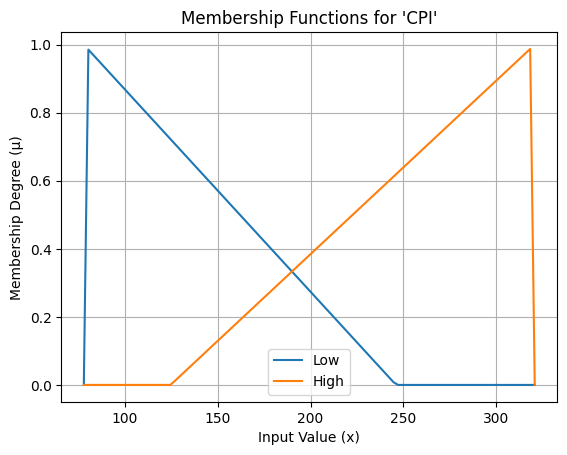

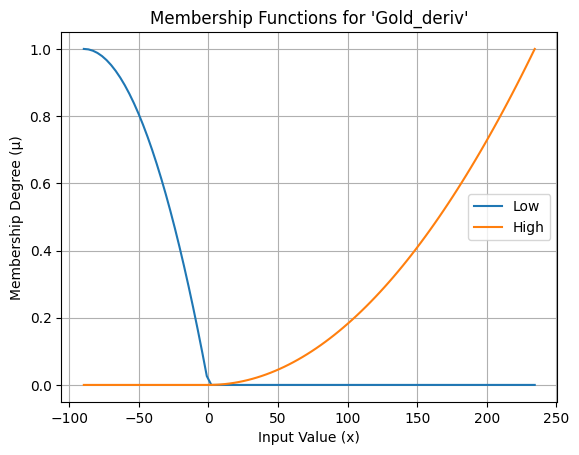

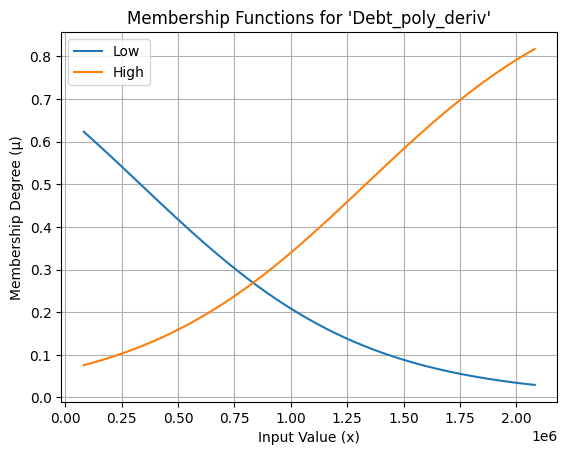

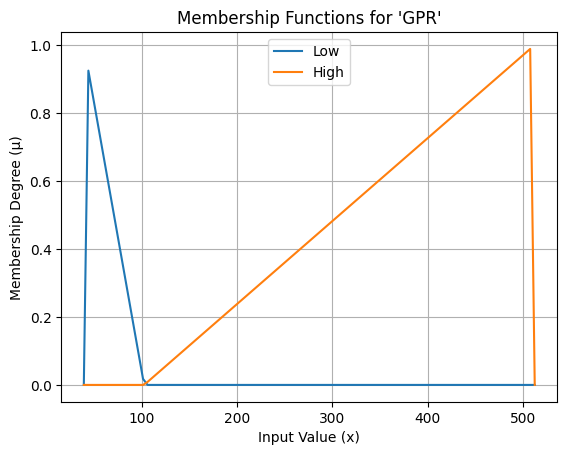

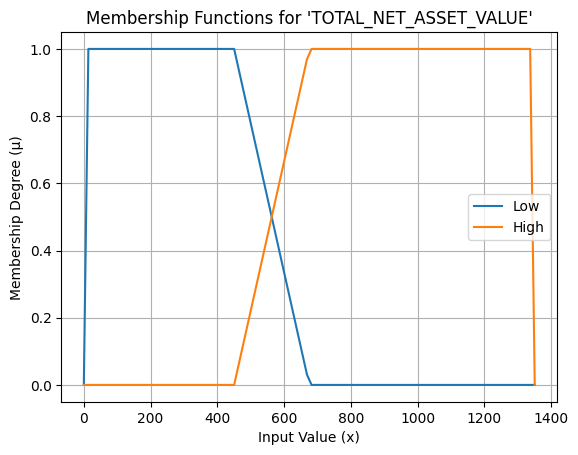

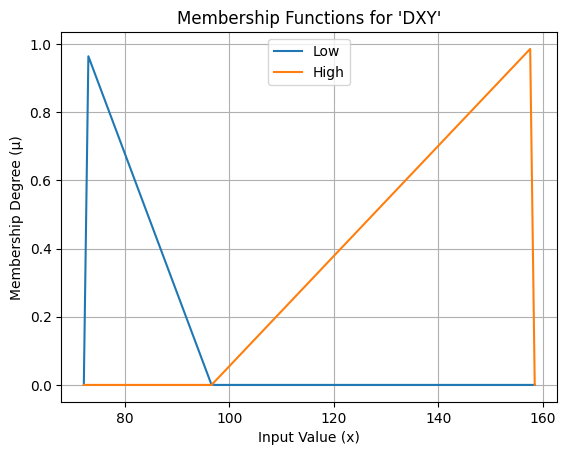

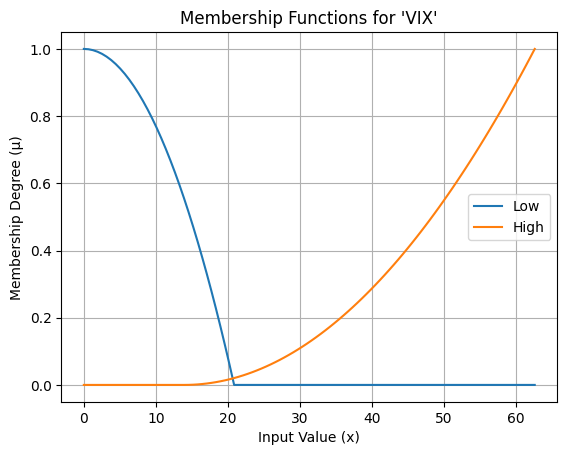

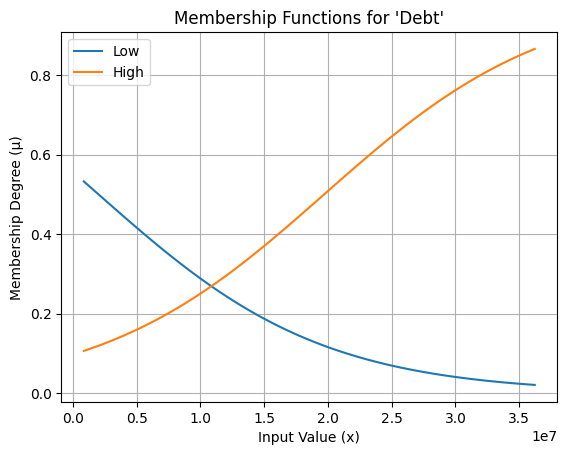

In [265]:
import FuzzyLogic as fl
#merged = merged.dropna()
merged = merged.fillna(0)
merged = merged[merged["Date"] >= "1980-01-01"]
print("cpi: ",merged["CPI"].min(), merged["CPI"].max(), merged["CPI"].mean())
print("Gold_deriv: ",merged["Gold_deriv"].min(), merged["Gold_deriv"].max(), merged["Gold_deriv"].mean())
print("Debt_poly_deriv: ",merged["Debt_poly_deriv"].min(), merged["Debt_poly_deriv"].max(), merged["Debt_poly_deriv"].mean())

print("GPR: ",merged["GPR"].min(), merged["GPR"].max(), merged["GPR"].mean())

print("TOTAL_NET_ASSET_VALUE: ",merged["TOTAL_NET_ASSET_VALUE"].min(), merged["TOTAL_NET_ASSET_VALUE"].max(), merged["TOTAL_NET_ASSET_VALUE"].mean())

print("DXY: ",merged["DXY"].min(), merged["DXY"].max(),  merged["DXY"].mean())

print("VIX: ",merged["VIX"].min(), merged["VIX"].max(),  merged["VIX"].mean())

print("Debt: ",merged["Debt"].min(), merged["Debt"].max(), merged["Debt"].mean())


# 1. DEBT — плавний ріст, стабільна структура → сигмоїдна
debt_min = merged["Debt"].min()
debt_max = merged["Debt"].max()
debt_mean = merged["Debt"].mean()
debt_spread = (debt_max - debt_min) / 4

debt_variable = fl.FuzzyLinguisticVariable("Debt", (debt_min, debt_max))
debt_variable.add_term(fl.FuzzyTerm("Low", fl.sigmoid_function(-1/debt_spread, debt_mean - debt_spread)))
debt_variable.add_term(fl.FuzzyTerm("High", fl.sigmoid_function(1/debt_spread, debt_mean + debt_spread)))

# 2. VIX — різкі коливання, високі стрибки → Z-shaped
vix_min = merged["VIX"].min()
vix_max = merged["VIX"].max()
vix_range = vix_max - vix_min
vix_low_high = vix_min + vix_range / 3
vix_high_low = vix_min + 2 * vix_range / 3

vix_variable = fl.FuzzyLinguisticVariable("VIX", (vix_min, vix_max))
vix_variable.add_term(fl.FuzzyTerm("Low", fl.z_shape_function(vix_min, vix_low_high)))
vix_variable.add_term(fl.FuzzyTerm("High", fl.z_shape_function(vix_low_high- vix_range/9, vix_max, inverse=True)))

# 3. DXY — стабільна, але зі зсувами → трикутна
dxy_min = merged["DXY"].min()
dxy_max = merged["DXY"].max()
dxy_mean = merged["DXY"].mean()
dxy_range = dxy_max - dxy_min

dxy_variable = fl.FuzzyLinguisticVariable("DXY", (dxy_min, dxy_max))
dxy_variable.add_term(fl.FuzzyTerm("Low", fl.triangle_function(dxy_min, dxy_min, dxy_mean)))
dxy_variable.add_term(fl.FuzzyTerm("High", fl.triangle_function(dxy_mean, dxy_max, dxy_max)))

# 4. TOTAL_NET_ASSET_VALUE — помірна мінливість → трапецієподібна
asset_min = merged["TOTAL_NET_ASSET_VALUE"].min()
asset_max = merged["TOTAL_NET_ASSET_VALUE"].max()
asset_range = asset_max - asset_min

asset_variable = fl.FuzzyLinguisticVariable("TOTAL_NET_ASSET_VALUE", (asset_min, asset_max))
asset_variable.add_term(fl.FuzzyTerm("Low", fl.trapezoidal_function(asset_min, asset_min , asset_min + asset_range / 3, asset_min + asset_range / 2)))
asset_variable.add_term(fl.FuzzyTerm("High", fl.trapezoidal_function(asset_min + asset_range / 3, asset_min + asset_range / 2, asset_max, asset_max)))

# 5. GPR — ризик змінюється стрибками → трикутна
gpr_min = merged["GPR"].min()
gpr_max = merged["GPR"].max()
gpr_mean = merged["GPR"].mean()
gpr_range = gpr_max - gpr_min

gpr_variable = fl.FuzzyLinguisticVariable("GPR", (gpr_min, gpr_max))
gpr_variable.add_term(fl.FuzzyTerm("Low", fl.triangle_function(gpr_min, gpr_min, gpr_mean)))
gpr_variable.add_term(fl.FuzzyTerm("High", fl.triangle_function(gpr_mean, gpr_max, gpr_max)))

# 6. Debt_poly_deriv — плавний ріст → сигмоїдна
debt_deriv_min = merged["Debt_poly_deriv"].min()
debt_deriv_max = merged["Debt_poly_deriv"].max()
debt_deriv_mean = merged["Debt_poly_deriv"].mean()
debt_deriv_spread = (debt_deriv_max - debt_deriv_min) / 4

debt_deriv_variable = fl.FuzzyLinguisticVariable("Debt_poly_deriv", (debt_deriv_min, debt_deriv_max))
debt_deriv_variable.add_term(fl.FuzzyTerm("Low", fl.sigmoid_function(-1/debt_deriv_spread, debt_deriv_mean - debt_deriv_spread)))
debt_deriv_variable.add_term(fl.FuzzyTerm("High", fl.sigmoid_function(1/debt_deriv_spread, debt_deriv_mean + debt_deriv_spread)))

# 7. Gold_deriv — спад або ріст з центром у 0 → гаусова
gold_deriv_min = merged["Gold_deriv"].min()
gold_deriv_max = merged["Gold_deriv"].max()
gold_deriv_mean = merged["Gold_deriv"].mean()
gold_deriv_range = gold_deriv_max - gold_deriv_min
gold_deriv_std = merged["Gold_deriv"].std() # Використаємо стандартне відхилення для ширини

gold_deriv_variable = fl.FuzzyLinguisticVariable("Gold_deriv", (gold_deriv_min, gold_deriv_max))
gold_deriv_variable.add_term(fl.FuzzyTerm("Low", fl.z_shape_function(gold_deriv_min, 0)))
gold_deriv_variable.add_term(fl.FuzzyTerm("High", fl.z_shape_function(0, gold_deriv_max,True)))

# 8. CPI — стабільне економічне зростання → сигмоїдна
cpi_min = merged["CPI"].min()
cpi_max = merged["CPI"].max()
cpi_mean = merged["CPI"].mean()
cpi_spread = (cpi_max - cpi_min) / 4
cpi_range = cpi_max - cpi_min


cpi_variable = fl.FuzzyLinguisticVariable("CPI", (cpi_min, cpi_max))
cpi_variable.add_term(fl.FuzzyTerm("Low", fl.triangle_function(cpi_min, cpi_min, cpi_mean + cpi_spread)))
cpi_variable.add_term(fl.FuzzyTerm("High", fl.triangle_function(cpi_mean - cpi_spread, cpi_max,cpi_max)))




fl.plot_linguistic_variable(cpi_variable)
fl.plot_linguistic_variable(gold_deriv_variable)
fl.plot_linguistic_variable(debt_deriv_variable)
fl.plot_linguistic_variable(gpr_variable)
fl.plot_linguistic_variable(asset_variable)
fl.plot_linguistic_variable(dxy_variable)
fl.plot_linguistic_variable(vix_variable)
fl.plot_linguistic_variable(debt_variable)



In [266]:
def prepare_fuzzy_forecast_data(merged: pd.DataFrame, months_ahead: int):
    """
    Підготовка даних для прогнозування ціни на золото з використанням нечіткої логіки.
    
    Args:
        merged (pd.DataFrame): Вхідний датафрейм зі змінними та Gold.
        months_ahead (int): Скільки місяців уперед прогнозувати.

    Returns:
        input_data_list (list[dict]): Список навчальних входів.
        forecast_input_rows (list[dict]): Останні рядки, які будуть використані для прогнозу.
        forecast_targets (list[float]): Фактичні значення золота через n місяців (тільки якщо вони є).
    """
    input_cols = ["GPR","TOTAL_NET_ASSET_VALUE", "Debt_poly_deriv", "Gold_deriv"]
    target_col = "Gold"
    
    # Видаляємо останні n рядків із цільовою змінною (бо у них немає майбутнього значення)
    X = merged[input_cols]
    y = merged[target_col].shift(-months_ahead)
    
    # Видаляємо рядки, де target стане NaN
    valid_data = merged.iloc[:-months_ahead].copy()
    valid_inputs = X.iloc[:-months_ahead].to_dict(orient="records")
    valid_targets = y.iloc[:-months_ahead].tolist()
    
    # Отримуємо останні months_ahead рядків, для яких будемо прогнозувати
    forecast_rows = X.iloc[-months_ahead:].to_dict(orient="records")
    
    return valid_inputs, forecast_rows, valid_targets


In [283]:
from matplotlib import pyplot as plt
from FuzzyLogic import HistoricalFuzzyRuleBase, generate_all_rules
from sklearn.preprocessing import MinMaxScaler
variables_dict = {
    "TOTAL_NET_ASSET_VALUE": asset_variable,
    "Debt_poly_deriv": debt_deriv_variable,
    "Gold_deriv": gold_deriv_variable,
    "GPR":gpr_variable,
}

# Generate all possible fuzzy rules
all_variables = list(variables_dict.values())
rules = generate_all_rules(all_variables)

# Create the historical fuzzy rule base
rule_base = HistoricalFuzzyRuleBase(variables_dict)
for rule in rules:
    rule_base.add_rule(rule)

# Підготовка навчальних даних та рядків для прогнозу
train_inputs, forecast_inputs, forecast_targets = prepare_fuzzy_forecast_data(merged, months_ahead=6)

input_columns = ["GPR","TOTAL_NET_ASSET_VALUE","Debt_poly_deriv","Gold_deriv"]


# Тренування
rule_base.prune_and_retrain(train_inputs, forecast_targets, 0 )

#truths = [rule.evaluate_truth(forecast_inputs[0], rule_base._variables) for rule in rule_base._rules]
#plt.hist(truths, bins=30)

#for rule in rule_base._rules:
#    print("rule coefs: ", rule._coefficients)


# Прогноз для останніх 3 місяців
predictions = [rule_base.predict(row) for row in forecast_inputs]
print(predictions)



[643.27, 627.15, 673.63, 661.15, 624.77, 538.26, 557.39, 499.76, 499.11, 495.8, 479.7, 461.09, 409.07, 410.16, 443.75, 437.76, 413.37, 410.09, 384.14, 374.13, 330.25, 350.3, 333.71, 314.98, 338.97, 364.23, 437.31, 422.15, 414.89, 444.5, 481.29, 491.09, 419.7, 432.88, 438.01, 412.84, 402.91, 416.2, 411.8, 393.6, 381.7, 388.34, 370.89, 385.96, 394.26, 381.37, 377.4, 377.7, 347.71, 347.7, 340.2, 341.0, 342.0, 319.54, 302.79, 299.1, 313.5, 326.8, 316.0, 316.5, 317.2, 330.4, 323.35, 325.85, 321.5, 321.9, 347.48, 338.89, 345.7, 340.44, 342.4, 342.7, 348.34, 376.66, 417.73, 423.51, 397.56, 390.92, 408.26, 401.12, 408.91, 438.35, 460.23, 449.59, 450.52, 461.15, 460.38, 465.35, 467.57, 486.24, 476.58, 442.07, 443.61, 451.55, 451.07, 451.33, 437.63, 431.28, 413.46, 406.78, 420.17, 419.05, 404.01, 387.51, 390.15, 384.4, 371.05, 367.6, 375.04, 365.14, 361.75, 366.88, 394.26, 409.39, 410.11, 416.81, 393.06, 374.24, 369.05, 352.33, 362.53, 394.73, 389.32, 380.74, 381.73, 376.95, 383.64, 363.83, 363.

In [284]:

fuzzy_variables = {
    "Debt": debt_variable,
    "VIX": vix_variable,
    "DXY": dxy_variable,
    "TOTAL_NET_ASSET_VALUE": asset_variable,
    "GPR": gpr_variable,
    "Debt_poly_deriv": debt_deriv_variable,
    "Gold_deriv": gold_deriv_variable,
    "CPI": cpi_variable,
}

for var_name, fuzzy_var in fuzzy_variables.items():
    filename = f"memberships/{var_name}.txt"
    with open(filename, "w") as f:
        header = f"{var_name}\t"
        terms = list(fuzzy_var._terms)
        header += "\t".join(terms) + "\n"
        f.write(header)
        for index, row in merged.iterrows():
            value = row[var_name]
            line = f"{value}\t"
            membership_values = [fuzzy_var._terms[term].get_membership_value(value) for term in terms]
            line += "\t".join(map(str, membership_values)) + "\n"
            f.write(line)


In [285]:

print("Функції належності для кожної змінної оцінено та записано у відповідні файли.")

Функції належності для кожної змінної оцінено та записано у відповідні файли.
